In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [2]:
def read_txt1(patha_name):
    with open(patha_name,'r') as f:
        data = f.readlines()
    data = [i.split(' ') for i in data]
    data1 = []
    for i in data:
        data2 = []
        for j in i :

            if j != '':
                data2.append(j)
        data1.append(data2)
    data1 = pd.DataFrame(data1)
    return data1
X_train = read_txt1('14cancer_xtrain.txt')
X_test = read_txt1('14cancer_xtest.txt')

In [3]:
X_train =X_train.iloc[1:,:]
X_train.index = range(len(X_train))
X_train.iloc[:,-1] =X_train.iloc[:,-1].apply(lambda x:x.replace('\n',''))
X_train = X_train.T
X_test =X_test.iloc[1:,:]
X_test.index = range(len(X_test))
X_test.iloc[:,-1] =X_test.iloc[:,-1].apply(lambda x:x.replace('\n',''))
X_test = X_test.T

In [9]:
X_train.head(2)

0     1     2     3     4     5     6     7     8     9      ... 16053  \
0   -73   -69   -48    13   -86  -147   -65   -71   -32   100  ...  -134   
1   -16   -63   -97   -42   -91  -164   -53   -77   -17   122  ...   -51   

  16054 16055 16056 16057 16058 16059 16060 16061 16062  
0   352   -67   121    -5   -11   -21   -41  -967  -120  
1   244   -15   119   -32     4   -14   -28  -205   -31  

[2 rows x 16063 columns]

In [4]:
patha_name = '14cancer_ytrain.txt'
with open(patha_name,'r') as f:
    Y_train = f.readlines()
Y_train = Y_train[0].split(' ')[1:]
patha_name = '14cancer_ytest.txt'
with open(patha_name,'r') as f:
    Y_test = f.readlines()
Y_test = Y_test[1].split(' ')[1:]

Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_train.iloc[-1,0] =Y_train.iloc[-1,0].replace('\n','')
Y_test.iloc[-1,0] =Y_test.iloc[-1,0].replace('\n','')

Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')
Y_train = Y_train-1
Y_test = Y_test-1

In [17]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(144, 16063) (54, 16063) (144, 14) (54, 14)


In [5]:
# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = Y_train.values
Y_test  = Y_test.values

In [6]:
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

In [7]:
# 训练模型
import time
def train(params):
    start_time = time.time()
    # 初始化 TabNet 回归模型
    from pytorch_tabnet.tab_model import TabNetClassifier
    import torch

    # 用于分类的 TabNet 模型参数
    tabnet_model = TabNetClassifier(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=3,
        gamma=1.3,
        n_independent=14,
        n_shared=2,
        epsilon=1e-15,
        momentum=0.02,
        lambda_sparse=params['lambda_sparse'],
        seed=42,
        clip_value=2,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=params['lr']),
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        scheduler_params={"step_size":params['Step_size'], "gamma":params['gamma']},
        mask_type="entmax",
        input_dim=10346,
        output_dim=14,  # 对于二分类任务，设为 1；对于多分类任务，设置为类别数
        device_name="cuda" if torch.cuda.is_available() else "cpu",
        verbose=0
    )

    # 训练模型
    tabnet_model.fit(
        X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        max_epochs=100,
        patience=30,
        batch_size=10,
        virtual_batch_size=5
    )

#     print(params)
#     print(np.min(tabnet_model.history['val_0_mse']))
    end_time = time.time()

    # 计算运行时间
    run_time = end_time - start_time
    print(f"程序运行时间：{run_time} 秒")
    return -np.max(tabnet_model.history['val_0_accuracy'])

In [8]:


param_grid_simple = {'lr': hp.uniform("lr",0.00005,0.1)
                     ,'Step_size':hp.randint('Step_size',290)
                     ,'gamma':hp.uniform('gamma',0.1,0.95)
                     ,'n_d':hp.randint('n_d',512)+1
                     ,'n_a':hp.randint('n_a',512)+1
                     ,'lambda_sparse': hp.uniform("lambda_sparse",0.00001,0.1)
                    }

def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    #algo = partial(tpe.suggest, n_startup_jobs=20, n_EI_candidates=50)
    params_best = fmin(train #目标函数
                       , space = param_grid_simple #参数空间
                       , algo = tpe.suggest 
                       #, algo = algo
                       , max_evals = max_evals #允许的迭代次数
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [9]:
param_hyperopt(max_evals=100)

                                                                                                                       
Early stopping occurred at epoch 94 with best_epoch = 64 and best_val_0_accuracy = 0.27778
  0%|                                                                          | 0/100 [14:29<?, ?trial/s, best loss=?]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：871.3184721469879 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 86 with best_epoch = 56 and best_val_0_accuracy = 0.2963
  1%|▍                                          | 1/100 [19:12<23:57:40, 871.32s/trial, best loss: -0.2777777777777778]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：281.8171856403351 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 82 with best_epoch = 52 and best_val_0_accuracy = 0.2963
  2%|▊                                          | 2/100 [23:28<14:16:46, 524.56s/trial, best loss: -0.2962962962962963]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：256.6940543651581 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 72 with best_epoch = 42 and best_val_0_accuracy = 0.31481
  3%|█▎                                         | 3/100 [29:05<10:50:17, 402.25s/trial, best loss: -0.2962962962962963]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：336.4346344470978 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 72 with best_epoch = 42 and best_val_0_accuracy = 0.27778
  4%|█▋                                         | 4/100 [37:36<10:02:01, 376.27s/trial, best loss: -0.3148148148148148]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：511.00950384140015 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 60 with best_epoch = 30 and best_val_0_accuracy = 0.25926
  5%|██▏                                        | 5/100 [38:42<11:12:41, 424.86s/trial, best loss: -0.3148148148148148]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：65.43129992485046 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 66 with best_epoch = 36 and best_val_0_accuracy = 0.27778
  6%|██▋                                         | 6/100 [49:58<7:54:09, 302.65s/trial, best loss: -0.3148148148148148]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：677.3526797294617 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 43 with best_epoch = 13 and best_val_0_accuracy = 0.22222
  7%|███                                        | 7/100 [53:57<10:58:59, 425.15s/trial, best loss: -0.3148148148148148]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：238.9526765346527 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 71 with best_epoch = 41 and best_val_0_accuracy = 0.33333
  8%|███▎                                      | 8/100 [1:07:29<9:21:00, 365.88s/trial, best loss: -0.3148148148148148]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：812.1409969329834 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 71 and best_val_0_accuracy = 0.33333              
  9%|███▋                                     | 9/100 [1:18:40<12:46:30, 505.39s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：670.4284539222717 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 66 with best_epoch = 36 and best_val_0_accuracy = 0.27778
 10%|████                                    | 10/100 [1:24:45<13:54:30, 556.34s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：365.4473249912262 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 59 with best_epoch = 29 and best_val_0_accuracy = 0.18519
 11%|████▍                                   | 11/100 [1:28:59<12:18:34, 497.92s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：253.66097784042358 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 48 with best_epoch = 18 and best_val_0_accuracy = 0.24074
 12%|████▊                                   | 12/100 [1:31:58<10:21:17, 423.61s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：178.75157189369202 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 55 with best_epoch = 25 and best_val_0_accuracy = 0.33333
 13%|█████▎                                   | 13/100 [1:35:43<8:26:41, 349.44s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：224.8540542125702 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 52 with best_epoch = 22 and best_val_0_accuracy = 0.38889
 14%|█████▋                                   | 14/100 [1:39:43<7:26:55, 311.81s/trial, best loss: -0.3333333333333333]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：240.5864713191986 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 60 with best_epoch = 30 and best_val_0_accuracy = 0.33333
 15%|██████▏                                  | 15/100 [1:46:24<6:51:18, 290.34s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：400.98638248443604 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 61 with best_epoch = 31 and best_val_0_accuracy = 0.2963
 16%|██████▌                                  | 16/100 [1:52:01<7:33:06, 323.65s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：337.1338951587677 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_accuracy = 0.35185
 17%|██████▉                                  | 17/100 [1:55:10<7:33:19, 327.70s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：188.71168851852417 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 81 with best_epoch = 51 and best_val_0_accuracy = 0.31481
 18%|███████▍                                 | 18/100 [2:11:32<6:30:46, 285.94s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：982.6643290519714 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 69 with best_epoch = 39 and best_val_0_accuracy = 0.31481
 19%|███████▌                                | 19/100 [2:19:21<11:08:30, 495.20s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：468.14488101005554 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 42 with best_epoch = 12 and best_val_0_accuracy = 0.24074
 20%|████████                                | 20/100 [2:22:43<10:49:26, 487.08s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：202.35416340827942 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 80 with best_epoch = 50 and best_val_0_accuracy = 0.25926
 21%|████████▌                                | 21/100 [2:29:30<8:48:47, 401.61s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：406.47194647789 秒                                                                                               
                                                                                                                       
Early stopping occurred at epoch 80 with best_epoch = 50 and best_val_0_accuracy = 0.31481
 22%|█████████                                | 22/100 [2:39:33<8:43:59, 403.07s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：602.8604028224945 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 55 with best_epoch = 25 and best_val_0_accuracy = 0.24074
 23%|█████████▍                               | 23/100 [2:43:36<9:54:13, 463.03s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：243.2495174407959 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_accuracy = 0.25926
 24%|█████████▊                               | 24/100 [2:46:17<8:22:58, 397.08s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：161.13281321525574 秒                                                                                            
Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_val_0_accuracy = 0.37037              
 25%|██████████▎                              | 25/100 [2:57:08<6:47:51, 326.29s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：650.8424682617188 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_accuracy = 0.25926
 26%|██████████▋                              | 26/100 [3:01:13<8:42:31, 423.67s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：245.21973586082458 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 53 with best_epoch = 23 and best_val_0_accuracy = 0.22222
 27%|███████████                              | 27/100 [3:10:29<7:30:19, 370.13s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：555.7603850364685 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 73 and best_val_0_accuracy = 0.31481              
 28%|███████████▍                             | 28/100 [3:19:50<8:30:59, 425.83s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：560.6731519699097 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 63 with best_epoch = 33 and best_val_0_accuracy = 0.33333
 29%|███████████▉                             | 29/100 [3:27:33<9:11:46, 466.28s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：463.7177460193634 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_accuracy = 0.31481
 30%|████████████▎                            | 30/100 [3:32:26<9:03:06, 465.52s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：293.067697763443 秒                                                                                              
                                                                                                                       
Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_accuracy = 0.25926
 31%|████████████▋                            | 31/100 [3:37:47<7:55:50, 413.78s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：320.798894405365 秒                                                                                              
                                                                                                                       
Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_accuracy = 0.11111
 32%|█████████████                            | 32/100 [3:42:38<7:17:20, 385.89s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：290.3319697380066 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 84 with best_epoch = 54 and best_val_0_accuracy = 0.27778
 33%|█████████████▌                           | 33/100 [3:55:06<6:38:53, 357.22s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：749.1600167751312 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 37 with best_epoch = 7 and best_val_0_accuracy = 0.27778
 34%|█████████████▉                           | 34/100 [3:59:27<8:42:17, 474.81s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：260.3434548377991 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 39 with best_epoch = 9 and best_val_0_accuracy = 0.25926
 35%|██████████████▎                          | 35/100 [4:01:46<7:24:40, 410.47s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：138.38575315475464 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 37 with best_epoch = 7 and best_val_0_accuracy = 0.27778
 36%|██████████████▊                          | 36/100 [4:03:00<5:50:46, 328.85s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：74.64602375030518 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 66 with best_epoch = 36 and best_val_0_accuracy = 0.2963
 37%|███████████████▏                         | 37/100 [4:14:22<4:25:13, 252.59s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：682.3851306438446 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_accuracy = 0.42593              
 38%|███████████████▌                         | 38/100 [4:26:59<6:34:14, 381.53s/trial, best loss: -0.3888888888888889]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：756.8697617053986 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 68 with best_epoch = 38 and best_val_0_accuracy = 0.31481
 39%|███████████████▌                        | 39/100 [4:39:18<8:22:22, 494.13s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：738.7220029830933 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 64 with best_epoch = 34 and best_val_0_accuracy = 0.22222
 40%|████████████████                        | 40/100 [4:43:00<9:27:30, 567.51s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：221.83623456954956 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 69 with best_epoch = 39 and best_val_0_accuracy = 0.31481
 41%|████████████████▍                       | 41/100 [4:44:05<7:36:04, 463.81s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：64.52150249481201 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 54 with best_epoch = 24 and best_val_0_accuracy = 0.27778
 42%|████████████████▊                       | 42/100 [4:46:36<5:32:33, 344.03s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：151.6619474887848 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 34 with best_epoch = 4 and best_val_0_accuracy = 0.22222
 43%|█████████████████▏                      | 43/100 [4:48:36<4:32:00, 286.32s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：119.53594255447388 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 68 with best_epoch = 38 and best_val_0_accuracy = 0.24074
 44%|█████████████████▌                      | 44/100 [5:00:49<3:40:32, 236.29s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：733.3059012889862 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 42 with best_epoch = 12 and best_val_0_accuracy = 0.25926
 45%|██████████████████                      | 45/100 [5:04:17<5:53:16, 385.40s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：208.40122318267822 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 59 with best_epoch = 29 and best_val_0_accuracy = 0.22222
 46%|██████████████████▍                     | 46/100 [5:14:14<4:59:04, 332.30s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：596.6741213798523 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 79 with best_epoch = 49 and best_val_0_accuracy = 0.31481
 47%|██████████████████▊                     | 47/100 [5:22:23<6:03:35, 411.61s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：488.70324969291687 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 51 with best_epoch = 21 and best_val_0_accuracy = 0.27778
 48%|███████████████████▏                    | 48/100 [5:25:45<6:16:46, 434.74s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：201.68923616409302 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 47 with best_epoch = 17 and best_val_0_accuracy = 0.27778
 49%|███████████████████▌                    | 49/100 [5:28:26<5:10:06, 364.83s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：161.53514432907104 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 43 with best_epoch = 13 and best_val_0_accuracy = 0.24074
 50%|████████████████████                    | 50/100 [5:30:27<4:13:12, 303.84s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：120.70642757415771 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.27778
 51%|████████████████████▍                   | 51/100 [5:41:03<3:23:16, 248.90s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：636.973370552063 秒                                                                                              
                                                                                                                       
Early stopping occurred at epoch 59 with best_epoch = 29 and best_val_0_accuracy = 0.24074
 52%|████████████████████▊                   | 52/100 [5:43:18<4:52:15, 365.33s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：133.83272886276245 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 77 with best_epoch = 47 and best_val_0_accuracy = 0.24074
 53%|█████████████████████▏                  | 53/100 [5:51:50<3:51:46, 295.88s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：512.1419911384583 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_val_0_accuracy = 0.35185              
 54%|█████████████████████▌                  | 54/100 [6:00:50<4:36:35, 360.76s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：540.3163073062897 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 90 with best_epoch = 60 and best_val_0_accuracy = 0.31481
 55%|██████████████████████                  | 55/100 [6:06:35<5:10:58, 414.63s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：345.0774140357971 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 49 with best_epoch = 19 and best_val_0_accuracy = 0.24074
 56%|██████████████████████▍                 | 56/100 [6:10:02<4:48:45, 393.77s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：206.25515961647034 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 77 with best_epoch = 47 and best_val_0_accuracy = 0.31481
 57%|██████████████████████▊                 | 57/100 [6:16:51<4:01:53, 337.52s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：409.4465606212616 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 38 with best_epoch = 8 and best_val_0_accuracy = 0.25926
 58%|███████████████████████▏                | 58/100 [6:24:26<4:11:22, 359.10s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：456.03463649749756 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 69 with best_epoch = 39 and best_val_0_accuracy = 0.27778
 59%|███████████████████████▌                | 59/100 [6:29:30<4:25:15, 388.18s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：303.1681070327759 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 38 with best_epoch = 8 and best_val_0_accuracy = 0.27778
 60%|████████████████████████                | 60/100 [6:32:22<4:01:47, 362.68s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：171.57999324798584 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 54 with best_epoch = 24 and best_val_0_accuracy = 0.25926
 61%|████████████████████████▍               | 61/100 [6:36:19<3:18:28, 305.35s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：237.05337262153625 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.31481
 62%|████████████████████████▊               | 62/100 [6:41:01<3:00:24, 284.86s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：282.13384318351746 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 60 with best_epoch = 30 and best_val_0_accuracy = 0.33333
 63%|█████████████████████████▏              | 63/100 [6:45:42<2:55:09, 284.05s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：281.10640120506287 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.35185
 64%|█████████████████████████▌              | 64/100 [6:54:04<2:49:54, 283.17s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：501.9615361690521 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 54 with best_epoch = 24 and best_val_0_accuracy = 0.25926
 65%|██████████████████████████              | 65/100 [6:58:30<3:23:28, 348.81s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：266.26598834991455 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 61 with best_epoch = 31 and best_val_0_accuracy = 0.2963
 66%|██████████████████████████▍             | 66/100 [7:03:16<3:03:37, 324.05s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：285.86536478996277 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 70 with best_epoch = 40 and best_val_0_accuracy = 0.27778
 67%|██████████████████████████▊             | 67/100 [7:12:14<2:51:55, 312.59s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：538.1415820121765 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 51 with best_epoch = 21 and best_val_0_accuracy = 0.18519
 68%|███████████████████████████▏            | 68/100 [7:14:18<3:22:48, 380.26s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：122.94618892669678 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 58 with best_epoch = 28 and best_val_0_accuracy = 0.31481
 69%|███████████████████████████▌            | 69/100 [7:20:04<2:36:35, 303.07s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：346.28782510757446 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_accuracy = 0.2037
 70%|████████████████████████████            | 70/100 [7:22:53<2:38:01, 316.04s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：169.70907378196716 秒                                                                                            
Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_val_0_accuracy = 0.33333              
 71%|████████████████████████████▍           | 71/100 [7:27:39<2:11:32, 272.14s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：285.8719174861908 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 81 with best_epoch = 51 and best_val_0_accuracy = 0.33333
 72%|████████████████████████████▊           | 72/100 [7:34:50<2:08:55, 276.26s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：431.0150074958801 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.2963
 73%|█████████████████████████████▏          | 73/100 [7:42:07<2:25:12, 322.69s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：437.3458523750305 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_accuracy = 0.24074
 74%|█████████████████████████████▌          | 74/100 [7:43:16<2:34:44, 357.09s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：68.31424117088318 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 78 with best_epoch = 48 and best_val_0_accuracy = 0.38889
 75%|██████████████████████████████          | 75/100 [7:59:51<1:52:41, 270.46s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：995.3636214733124 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 79 with best_epoch = 49 and best_val_0_accuracy = 0.40741
 76%|██████████████████████████████▍         | 76/100 [8:14:10<3:15:10, 487.93s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：859.315610408783 秒                                                                                              
                                                                                                                       
Early stopping occurred at epoch 86 with best_epoch = 56 and best_val_0_accuracy = 0.31481
 77%|██████████████████████████████▊         | 77/100 [8:23:34<3:49:45, 599.35s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：563.9066834449768 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 69 with best_epoch = 39 and best_val_0_accuracy = 0.18519
 78%|███████████████████████████████▏        | 78/100 [8:30:14<3:35:51, 588.72s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：399.11222314834595 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.2963
 79%|███████████████████████████████▌        | 79/100 [8:31:52<3:06:08, 531.84s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：97.89899253845215 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 46 with best_epoch = 16 and best_val_0_accuracy = 0.31481
 80%|████████████████████████████████        | 80/100 [8:37:10<2:13:53, 401.66s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：318.9284245967865 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 70 and best_val_0_accuracy = 0.35185              
 81%|████████████████████████████████▍       | 81/100 [8:47:43<1:59:20, 376.84s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：632.3461079597473 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 79 with best_epoch = 49 and best_val_0_accuracy = 0.27778
 82%|████████████████████████████████▊       | 82/100 [8:52:48<2:16:02, 453.50s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：305.153222322464 秒                                                                                              
                                                                                                                       
Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_accuracy = 0.2963
 83%|█████████████████████████████████▏      | 83/100 [8:57:29<1:55:52, 409.00s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：281.4404857158661 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 74 and best_val_0_accuracy = 0.33333              
 84%|█████████████████████████████████▌      | 84/100 [9:07:28<1:38:51, 370.73s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：598.7797200679779 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 67 with best_epoch = 37 and best_val_0_accuracy = 0.2963
 85%|██████████████████████████████████      | 85/100 [9:11:04<1:49:47, 439.15s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：215.2393925189972 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 39 with best_epoch = 9 and best_val_0_accuracy = 0.24074
 86%|██████████████████████████████████▍     | 86/100 [9:17:09<1:26:47, 371.98s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：365.5490708351135 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 82 with best_epoch = 52 and best_val_0_accuracy = 0.2963
 87%|██████████████████████████████████▊     | 87/100 [9:29:04<1:20:10, 370.05s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：715.3742113113403 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 66 with best_epoch = 36 and best_val_0_accuracy = 0.2963
 88%|███████████████████████████████████▏    | 88/100 [9:40:46<1:34:43, 473.65s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：702.0399086475372 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 83 with best_epoch = 53 and best_val_0_accuracy = 0.37037
 89%|███████████████████████████████████▌    | 89/100 [9:54:36<1:39:23, 542.17s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：829.6356897354126 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 78 with best_epoch = 48 and best_val_0_accuracy = 0.35185
 90%|████████████████████████████████████    | 90/100 [9:59:23<1:44:44, 628.41s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：286.88814544677734 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 61 with best_epoch = 31 and best_val_0_accuracy = 0.2963
 91%|███████████████████████████████████▍   | 91/100 [10:03:59<1:18:53, 525.96s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：275.98273253440857 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 39 with best_epoch = 9 and best_val_0_accuracy = 0.22222
 92%|███████████████████████████████████▉   | 92/100 [10:09:54<1:00:07, 450.97s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：355.0544936656952 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 90 with best_epoch = 60 and best_val_0_accuracy = 0.27778
 93%|██████████████████████████████████████▏  | 93/100 [10:15:08<49:15, 422.20s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：313.9944763183594 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 69 with best_epoch = 39 and best_val_0_accuracy = 0.2037
 94%|██████████████████████████████████████▌  | 94/100 [10:21:41<38:58, 389.74s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：393.0266954898834 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_accuracy = 0.27778
 95%|██████████████████████████████████████▉  | 95/100 [10:26:31<32:33, 390.73s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：290.05362010002136 秒                                                                                            
                                                                                                                       
Early stopping occurred at epoch 96 with best_epoch = 66 and best_val_0_accuracy = 0.33333
 96%|███████████████████████████████████████▎ | 96/100 [10:35:59<24:02, 360.53s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：567.8892669677734 秒                                                                                             
Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_val_0_accuracy = 0.35185              
 97%|███████████████████████████████████████▊ | 97/100 [10:40:15<21:08, 422.74s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：255.8218288421631 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 65 with best_epoch = 35 and best_val_0_accuracy = 0.14815
 98%|████████████████████████████████████████▏| 98/100 [10:49:11<12:25, 372.67s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：536.7061986923218 秒                                                                                             
                                                                                                                       
Early stopping occurred at epoch 50 with best_epoch = 20 and best_val_0_accuracy = 0.33333
 99%|████████████████████████████████████████▌| 99/100 [10:52:15<07:01, 421.88s/trial, best loss: -0.42592592592592593]

C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



程序运行时间：183.36316895484924 秒                                                                                            
100%|████████████████████████████████████████| 100/100 [10:52:16<00:00, 391.36s/trial, best loss: -0.42592592592592593]

 
 best params:  {'Step_size': 95, 'gamma': 0.6241254398107915, 'lambda_sparse': 0.09614552676877053, 'lr': 0.014403915888532511, 'n_a': 230, 'n_d': 437} 



({'Step_size': 95,
  'gamma': 0.6241254398107915,
  'lambda_sparse': 0.09614552676877053,
  'lr': 0.014403915888532511,
  'n_a': 230,
  'n_d': 437},
 <hyperopt.base.Trials at 0x206d7b32d30>)

In [7]:
# 训练模型
from pytorch_tabnet.tab_model import TabNetClassifier
params = {'Step_size': 95,
  'gamma': 0.6241254398107915,
  'lambda_sparse': 0.09614552676877053,
  'lr': 0.014403915888532511,
  'n_a': 230+1,
  'n_d': 437+1}
tabnet_model = TabNetClassifier(
    n_d=params['n_d'],
    n_a=params['n_a'],
    n_steps=3,
    gamma=1.3,
    n_independent=14,
    n_shared=2,
    epsilon=1e-15,
    momentum=0.02,
    lambda_sparse=params['lambda_sparse'],
    seed=42,
    clip_value=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=params['lr']),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":params['Step_size'], "gamma":params['gamma']},
    mask_type="entmax",
    input_dim=10346,
    output_dim=14,  # 对于二分类任务，设为 1；对于多分类任务，设置为类别数
    device_name="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0
)

# 训练模型
tabnet_model.fit(
    X_train, Y_train,
    eval_set=[(X_test, Y_test)],
    max_epochs=100,
    patience=30,
    batch_size=10,
    virtual_batch_size=5
)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_accuracy = 0.42593


C:\Users\Administrator\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [11]:
Y_test.shape

(54, 1)

In [9]:

total_params = sum(p.numel() for p in tabnet_model.network.parameters())

print(total_params)


83983933


In [8]:
torch.save(tabnet_model, 'tabnet_model.pth')

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tabnet_model = torch.load('tabnet_model.pth')
# scores = tabnet_model.predict(X_test)
scores = tabnet_model.predict_proba(X_test)
y_test = Y_test.copy()

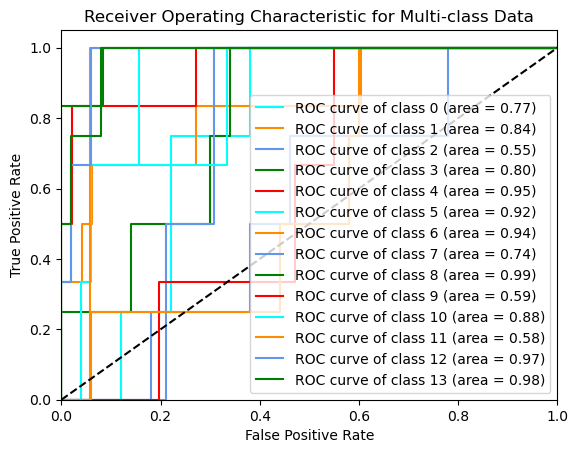

In [27]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle



# 二值化标签
y_test_bin = label_binarize(y_test, classes=list(range(14)))

n_classes = 14


# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 画出所有的ROC曲线
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class Data')
plt.legend(loc="lower right")
plt.show()


In [30]:
from sklearn.metrics import classification_report

predicted = np.argmax(scores, axis=1)
print(classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       0.17      0.25      0.20         4
           3       0.00      0.00      0.00         4
           4       0.55      1.00      0.71         6
           5       0.25      0.33      0.29         3
           6       0.25      1.00      0.40         2
           7       0.00      0.00      0.00         2
           8       1.00      0.83      0.91         6
           9       0.00      0.00      0.00         3
          10       0.33      0.67      0.44         3
          11       0.00      0.00      0.00         4
          12       0.75      1.00      0.86         3
          13       0.43      0.75      0.55         4

    accuracy                           0.43        54
   macro avg       0.27      0.42      0.31        54
weighted avg       0.30      0.43      0.34        54



C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# 获取特征重要性
feature_importances = tabnet_model.feature_importances_

# 可视化特征重要性
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances,width=20)
plt.xlabel('Feature indices')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()